In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks, preprocessing, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from warnings import filterwarnings
filterwarnings("ignore")
import random as rand
seed = 42
import random as rand

2025-07-31 17:02:15.863678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753981336.237970      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753981336.345733      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = r"/kaggle/input/balanced-fer-dataset-7575-grayscale/train"
test = r"/kaggle/input/balanced-fer-dataset-7575-grayscale/test"
val = r"/kaggle/input/balanced-fer-dataset-7575-grayscale/val"

In [3]:
import os
import csv
path_train = train
path_test = test
path_val = val


csv_file_train = "train.csv"
csv_file_test = "test.csv"
csv_file_val = "val.csv"

def make_csv_file(csv_file , main_folder):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['path', 'label'])


        for label in os.listdir(main_folder):
            folder_path = os.path.join(main_folder, label)
            if os.path.isdir(folder_path):
                for image_name in os.listdir(folder_path):
                    image_path = os.path.join(folder_path, image_name)
                    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        writer.writerow([image_path, label])



make_csv_file(csv_file_train , path_train)
make_csv_file(csv_file_test , path_test)
make_csv_file(csv_file_val , path_val)

In [4]:
train = pd.read_csv(r"/kaggle/working/train.csv")
test = pd.read_csv(r"/kaggle/working/test.csv")
val = pd.read_csv(r"/kaggle/working/val.csv")


In [5]:
train

,path,label
0,/kaggle/input/balanced-fer-dataset-7575-graysc...,surprise
1,/kaggle/input/balanced-fer-dataset-7575-graysc...,surprise
2,/kaggle/input/balanced-fer-dataset-7575-graysc...,surprise
3,/kaggle/input/balanced-fer-dataset-7575-graysc...,surprise
4,/kaggle/input/balanced-fer-dataset-7575-graysc...,surprise
...,...,...
45299,/kaggle/input/balanced-fer-dataset-7575-graysc...,happy
45300,/kaggle/input/balanced-fer-dataset-7575-graysc...,happy
45301,/kaggle/input/balanced-fer-dataset-7575-graysc...,happy
45302,/kaggle/input/balanced-fer-dataset-7575-graysc...,happy


In [6]:
print(train.shape)
print(test.shape)
print(val.shape)

(45304, 2)
(6286, 2)
(11326, 2)


In [7]:
Total_Images = train.shape[0]
print(f"Total Train images :{Total_Images}\n")

num_classes = train['label'].nunique()
print(f"Unique Classes: {num_classes}\n")

classes = train['label'].unique()
print("Classes:", classes)

Total Train images :45304

Unique Classes: 7

Classes: ['surprise' 'fear' 'angry' 'neutral' 'sad' 'disgust' 'happy']


In [8]:
train["label"].value_counts()

label
surprise    6472
fear        6472
angry       6472
neutral     6472
sad         6472
disgust     6472
happy       6472
Name: count, dtype: int64

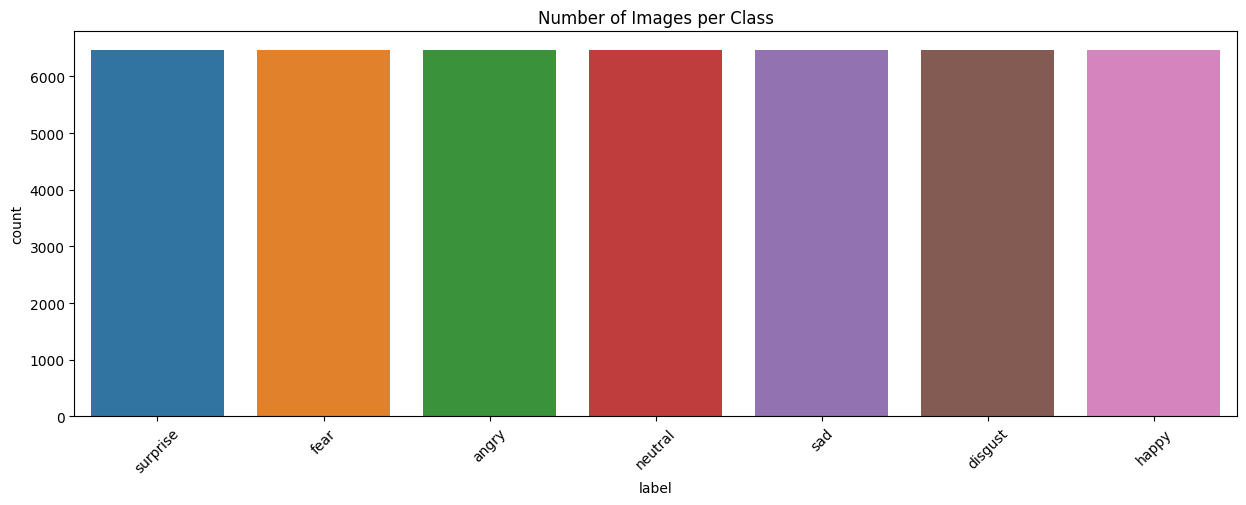

In [9]:
plt.figure(figsize=(15,5))
sns.countplot(data=train, x='label', order=train['label'].value_counts().index)
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.show()

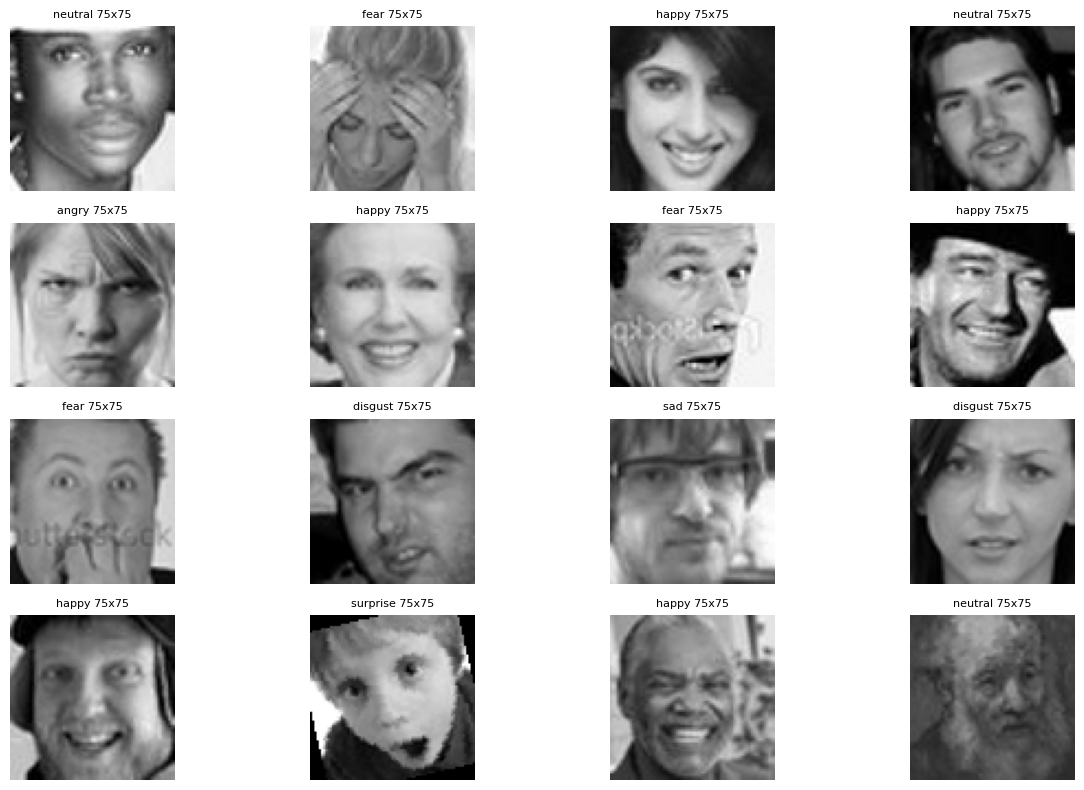

In [10]:
# -- show sample of data --

plt.figure(figsize=(13 , 8))

for i in range(0 , 16):
    num = rand.randint(0, len(train["path"]) - 1)
    image_path = train.iloc[num]["path"]
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # -- convert image to BGR to RGB --
        h, w = image.shape[:2]
        plt.subplot(4, 4, i+1)
        plt.imshow(image)
        plt.title(f"{train.iloc[num]['label']} {w}x{h}", fontsize=8)  # -- image label and dimention --
        plt.axis("off")
    else:
        print(f"Image at {image_path} not found!")

plt.tight_layout()
plt.show()

In [ ]:
# -- Reading data -- 

IMG_SIZE = (75, 75)
BATCH_SIZE = 32


train_ds = preprocessing.image_dataset_from_directory(
    f'{train}',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=33,
    label_mode='categorical',
    color_mode='grayscale'
)

val_ds = preprocessing.image_dataset_from_directory(
    f'{val}',
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale'
)

test_ds = preprocessing.image_dataset_from_directory(
    f'{test}',
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale'
)

Found 45304 files belonging to 7 classes.


I0000 00:00:1753981374.630960      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753981374.631716      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 11326 files belonging to 7 classes.
Found 6286 files belonging to 7 classes.


In [13]:
# from tensorflow.keras import layers

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
#     tf.keras.layers.RandomContrast(0.2),
#     tf.keras.layers.RandomBrightness(factor=0.1),
# ])

In [ ]:
# -- Model Architecture 


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Input

model = Sequential([
    Input(shape=(75, 75, 1)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),  
    MaxPooling2D((2, 2)),
    Dropout(0.25),  

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


In [ ]:
# -- Summarize model --

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,207,399 (4.61 MB)

 Trainable params: 1,206,439 (4.60 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
# -- Model compiling --
from tensorflow.keras.optimizers import Adam

model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# -- call backs (EarlyStopping , ModelCheckpoint , ReduceLROnPlateau)

my_callbacks  = [
    
    EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

In [18]:
# -- model Fit --

history = model.fit(
    train_ds,
    epochs=60,
    validation_data=val_ds,
    callbacks=[my_callbacks ]
)


Epoch 1/60


I0000 00:00:1753981391.980744     103 service.cc:148] XLA service 0x7830d8012780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753981391.982015     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753981391.982034     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753981392.761443     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1416 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.1495 - loss: 2.4203 

I0000 00:00:1753981401.569870     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1416/1416 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1657 - loss: 1.9800
Epoch 1: val_loss improved from inf to 1.84442, saving model to best_model.keras
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 88s 51ms/step - accuracy: 0.1657 - loss: 1.9800 - val_accuracy: 0.2428 - val_loss: 1.8444 - learning_rate: 0.0010
Epoch 2/60
1414/1416 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2221 - loss: 1.8405
Epoch 2: val_loss improved from 1.84442 to 1.73192, saving model to best_model.keras
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.2222 - loss: 1.8404 - val_accuracy: 0.2939 - val_loss: 1.7319 - learning_rate: 0.0010
Epoch 3/60
1414/1416 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3110 - loss: 1.7023
Epoch 3: val_loss improved from 1.73192 to 1.46554, saving model to best_model.keras
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.3110 - loss: 1.7022 - val_accuracy: 0.4287 - val_loss: 1.4655 - learning_rate: 0.0010
Epoch 4/60
1414/1416 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - a

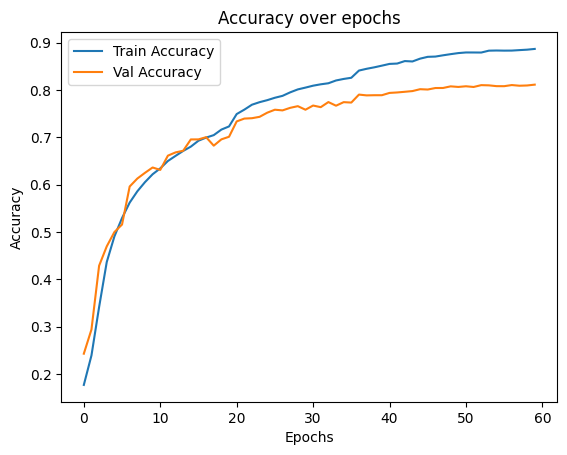

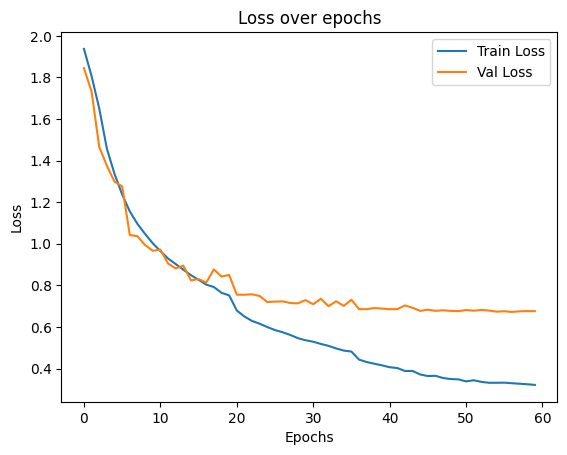

In [19]:
# -- Plot training vs validation accuracy --
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# -- Plot training vs validation loss --
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)


197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.8146 - loss: 0.6702
Loss: 0.6704524755477905
Accuracy: 0.8141902685165405


197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


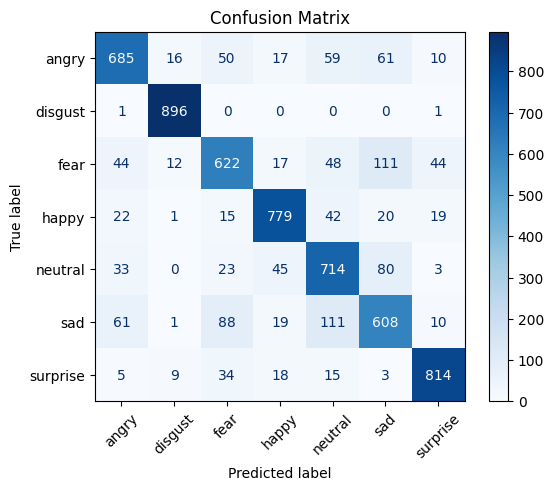

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test = []
y_test = []

for images, labels in test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# -- predict test data -- 
y_pred = model.predict(X_test)


y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# -- Confusion Matrix --
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

X_test = []
y_true = []

for images, labels in test_ds:
    X_test.append(images.numpy())
    y_true.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_true = np.argmax(np.concatenate(y_true, axis=0), axis=1)


y_pred_probs = model.predict(X_test, batch_size=64, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)


class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.80      0.76      0.78       898
     disgust       0.96      1.00      0.98       898
        fear       0.75      0.69      0.72       898
       happy       0.87      0.87      0.87       898
         sad       0.72      0.80      0.76       898
    surprise       0.69      0.68      0.68       898
     neutral       0.90      0.91      0.90       898

    accuracy                           0.81      6286
   macro avg       0.81      0.81      0.81      6286
weighted avg       0.81      0.81      0.81      6286

